In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor
from PIL import Image
import matplotlib.pyplot as plt

In [48]:
def plot_tensor(tensor, title=None, save=False):
    tensor = tensor.detach().cpu().numpy()
    plt.imshow(tensor, cmap='inferno')
    # plt.imshow(tensor)
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()
    if save:
        plt.savefig(title + '.png')
    plt.close()

In [49]:

class InterpretableConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, feature_map_size, tau=0.5, beta=4.0, alpha=0.95):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size, padding=1, bias=True)
        self.tau = tau
        self.beta = beta
        self.alpha = alpha
        self.n = feature_map_size
        self.templates = self._generate_templates()

    def forward(self, x):
        x = F.relu(self.conv(x))
        masks = self._assign_masks(x)
        return x * masks  # masked feature map

    def _generate_templates(self):
        templates = []
        for i in range(self.n):
            for j in range(self.n):
                t = torch.full((self.n, self.n), -self.tau)
                for x in range(self.n):
                    for y in range(self.n):
                        dist = abs(x - i) + abs(y - j)
                        t[x, y] = self.tau * max(1 - self.beta * dist / self.n, -1)
                templates.append(t)
        return torch.stack(templates)

    def _assign_masks(self, x):
        B, C, H, W = x.shape
        x_flat = x.view(B * C, H, W)
        masks = []

        for fmap in x_flat:
            mu_hat = torch.argmax(fmap.view(-1))
            i, j = mu_hat // self.n, mu_hat % self.n
            idx = i * self.n + j
            mask = self.templates[idx]
            masks.append(mask)

        masks = torch.stack(masks).view(B, C, H, W).to(x.device)
        return masks


In [50]:
filters = 5
cnn = InterpretableConvLayer(3, 5, 3, 32)

In [51]:
cnn.templates.shape

torch.Size([1024, 32, 32])

In [52]:
image = Image.open("examples/fish_32_32.png")
image_as_tensor = ToTensor()(image).unsqueeze(0)[:, :3, :, :]
image_as_tensor.shape

torch.Size([1, 3, 32, 32])

In [53]:
output = cnn(image_as_tensor)
output.shape

torch.Size([1, 5, 32, 32])

In [54]:
output.max()

tensor(0.3236, grad_fn=<MaxBackward1>)

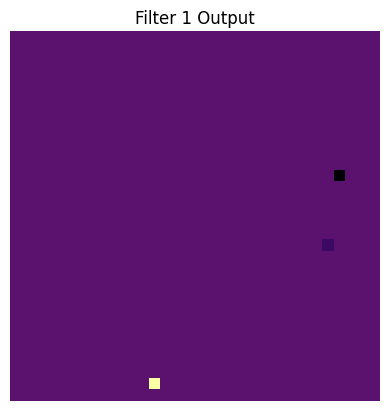

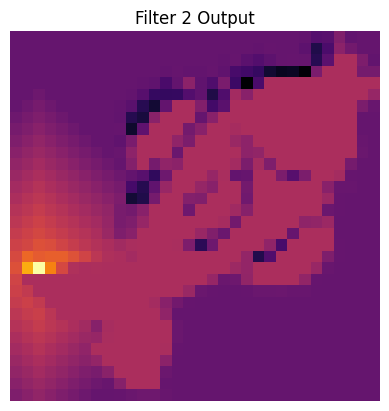

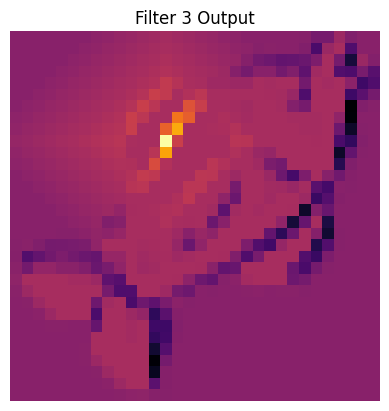

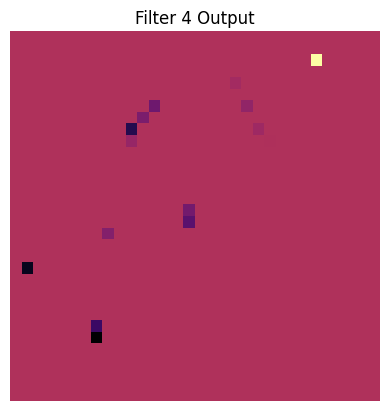

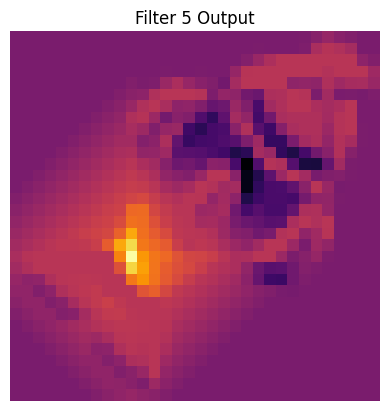

In [55]:
for i in range(filters):
    image = output[0, i, :, :]
    plot_tensor(image, title=f"Filter {i+1} Output")

In [ ]:
def mutual_information(feature_maps, templates, τ=0.02, log_base=2):

    templates = templates.unsqueeze(0)

    feature_maps_activated = feature_maps > τ
    templates_activated = templates > τ

    print(feature_maps_activated.shape, "feature_maps_activated")
    print(templates_activated.shape, "templates_activated")

    first_filter = feature_maps_activated[:, 2, :, :].unsqueeze(1)
    # print(first_filter.shape, "first_filter")
    first_template = templates_activated[:, 10, :, :].unsqueeze(1)
    # print(first_template.shape, "first_template")

    plot_tensor(first_filter[0][0], title="First Filter")
    plot_tensor(first_template[0][0], title="First Template")
    
    #calculate the joint probability
    joint_prob = (first_filter * first_template).float()
    plot_tensor(joint_prob[0][0], title="Joint Probability")

    first_filter_prob = first_filter.flatten(start_dim=2).sum(dim=2)
    first_template_prob = first_template.flatten(start_dim=2).sum(dim=2)
    joint_prob = joint_prob.flatten(start_dim=2).sum(dim=2)
    # print(first_filter_prob, "first_filter_prob")
    # print(first_template_prob, "first_template_prob")
    # print(joint_prob, "joint_prob")

    # Calculate mi
    mi = -1 * joint_prob * torch.log2(joint_prob / (first_filter_prob * first_template_prob + 1e-10) + 1e-10)
    return mi


torch.Size([1, 5, 32, 32]) feature_maps_activated
torch.Size([1, 1024, 32, 32]) templates_activated


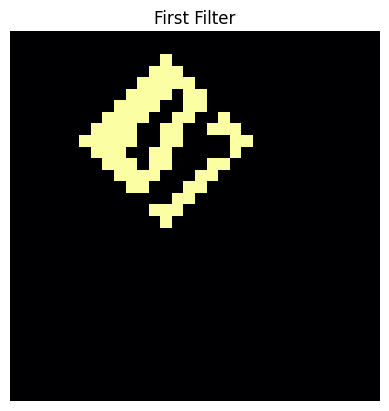

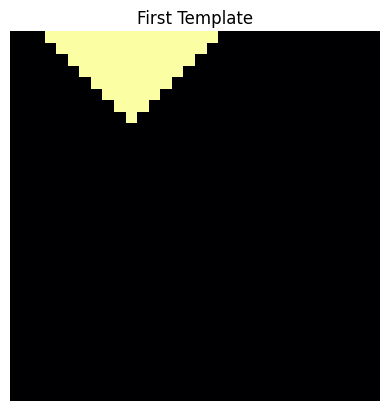

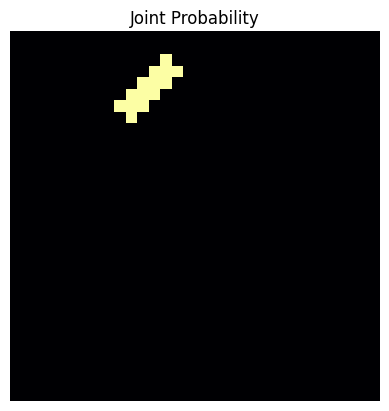

In [67]:
x = mutual_information(output, cnn.templates, τ=0.001, log_base=2)

In [94]:
def mutual_information(feature_maps, templates, τ=0.02, log_base=2):

    n_x_n = feature_maps.shape[2] * feature_maps.shape[3]
    templates = templates.unsqueeze(0)

    feature_maps_activated = feature_maps > τ
    templates_activated = templates > τ

    print(feature_maps_activated.shape, "feature_maps_activated")
    print(templates_activated.shape, "templates_activated")

    feature_maps_extended  = feature_maps_activated.unsqueeze(2)   # (1, 5, 1,   32, 32)
    templates_extended  = templates_activated.unsqueeze(1) 
    print(feature_maps_extended.shape, "feature_maps_extended")
    print(templates_extended.shape, "templates_extended")

    joint  = torch.logical_and(feature_maps_extended, templates_extended)
    print(joint.shape, "joint")

    feature_maps_prob = feature_maps_activated.flatten(start_dim=2).sum(dim=2) / n_x_n
    templates_prob = templates_activated.flatten(start_dim=2).sum(dim=2) / n_x_n
    print(feature_maps_prob, "feature_maps_prob")
    print(templates_prob, "templates_prob")

    # first_template_prob = first_template.flatten(start_dim=2).sum(dim=2)
    joint_prob = joint.flatten(start_dim=3).sum(dim=3) / n_x_n
    print(joint_prob.max(dim=2), "joint_prob") 
    # print(first_filter_prob, "first_filter_prob")
    # print(first_template_prob, "first_template_prob")
    # print(joint_prob, "joint_prob")

    # Calculate mi
    (feature_maps_prob * templates_prob + 1e-10)
    # mi = -1 * joint * torch.log2(joint_prob / (first_filter_prob * first_template_prob + 1e-10) + 1e-10)
    return 0

In [95]:
x = mutual_information(output, cnn.templates, τ=0.001, log_base=2)

torch.Size([1, 5, 32, 32]) feature_maps_activated
torch.Size([1, 1024, 32, 32]) templates_activated
torch.Size([1, 5, 1, 32, 32]) feature_maps_extended
torch.Size([1, 1, 1024, 32, 32]) templates_extended
torch.Size([1, 5, 1024, 32, 32]) joint
tensor([[0.0010, 0.0635, 0.0732, 0.0010, 0.0889]]) feature_maps_prob
tensor([[0.0352, 0.0420, 0.0479,  ..., 0.0479, 0.0420, 0.0352]]) templates_prob
torch.return_types.max(
values=tensor([[0.0010, 0.0635, 0.0732, 0.0010, 0.0889]]),
indices=tensor([[748, 642, 301,  21, 618]])) joint_prob


RuntimeError: The size of tensor a (5) must match the size of tensor b (1024) at non-singleton dimension 1

In [286]:
import torch, math

def entropy_from_peaks(feature_maps, τ=0.0, log_base=2):
    """
    Calcula la entropía H(X) de los picos de activación.
    
    feature_maps : Tensor [B, F, H, W]
        Salida de tu InterpretableConvLayer
    τ            : float
        Umbral mínimo para considerar que el filtro “se activó”.
        Si el valor máximo del mapa < τ → contamos la posición “negativa”.
    log_base     : 2 | math.e | 10
        Base del logaritmo para medir bits, nats o hartleys.
    
    Devuelve
    ---------
    entropies : Tensor [F]
        Entropía (una por filtro).
    """
    B, F, H, W = feature_maps.shape
    N_pos = H * W                       # n² celdas posibles
    NEG   = N_pos                       # índice de la plantilla negativa
    
    # 1️⃣ Localizamos picos e índices lineales   ──────────────────────────
    flat_maps      = feature_maps.flatten(start_dim=2)       # [B, F, H·W]
    print(flat_maps.shape)
    peak_vals, idx = flat_maps.max(dim=2)                    # ambos [B, F]
    print(peak_vals.shape, idx.shape)
    print(idx)
    
    # 2️⃣ Construimos histograma por filtro       ──────────────────────────
    #    hist[f, i] = cuántas imágenes dieron su pico en la celda i
    hist = torch.zeros(F, N_pos + 1, device=feature_maps.device)
    print(hist.shape, "hist")

    #   - vectorizamos: elegimos NEG donde el pico < τ
    idx = torch.where(peak_vals > τ, idx, torch.full_like(idx, NEG))
    print(idx, "idx")
    
    #   - convertimos a one-hot y acumulamos sobre el lote
    one_hot = torch.nn.functional.one_hot(idx, num_classes=N_pos + 1)  # [B, F, N_pos+1]
    print(one_hot.shape)
    hist   += one_hot.sum(dim=0, dtype=torch.float32)                  #   ↑  suma sobre B
    print(hist.shape, "hist new")
    print(hist, "hist")
    
    # 3️⃣ Probabilidades y entropía               ──────────────────────────
    print(hist.sum(dim=1, keepdim=True), "hist sum")
    p = hist / hist.sum(dim=1, keepdim=True)          # [F, N_pos+1]
    # evitamos log(0) con un eps pequeño
    eps = 1e-12
    logp = p.clamp_min(eps).log() / math.log(log_base)
    
    entropies = -(p * logp).sum(dim=1)                # [F]
    return entropies


In [24]:
class Model(nn.Module):
    def __init__(self, feature_map_size):
        super().__init__()
        self.interp = InterpretableConvLayer(in_channels=3, out_channels=1, kernel_size=3, feature_map_size=feature_map_size)
        self.classifier = nn.Linear(feature_map_size * feature_map_size, 1)  # Binary classification

    def forward(self, x):
        feats = self.interp(x)
        pooled = F.adaptive_avg_pool2d(feats, (self.interp.n, self.interp.n))
        flat = pooled.view(pooled.size(0), -1)
        logits = self.classifier(flat)
        return logits, feats.squeeze(1)  # return also the feature map for loss


In [25]:
# Iterate over both folders, Cat and Dog
def load_data(cat_folder, dog_folder):
    # Placeholder for loading data from cat_folder and dog_folder
    # This function should return a DataLoader for the dataset
    os.walk(cat_folder)

In [26]:
from catdog_dataset import CatDogDataset

In [27]:
dataset_path = './PetImages/'

In [28]:
dataset = CatDogDataset(None, dataset_path)

In [29]:
len(dataset), dataset[0][0].shape, dataset[0][1]

(24998, torch.Size([3, 128, 128]), 0)

In [30]:
dataloader = torch.utils.data.DataLoader(
    dataset,
    batch_size=32,
    shuffle=True,
    num_workers=4
)

In [31]:
dataset[0][0].shape, dataset[0][1]

(torch.Size([3, 128, 128]), 0)

In [32]:
image = dataset[0][0]

In [40]:
cnn = InterpretableConvLayer(3, 5, 3, 7)

In [41]:
cnn.templates.shape

torch.Size([49, 7, 7])

In [42]:
image = torch.randn(1, 3, 7, 7)
cnn(image).shape

torch.Size([1, 5, 7, 7])

In [16]:
# Supón que tienes:
# images: [B, 3, H, W]
# labels: [B] (0 o 1)

model = Model(feature_map_size=7).to("mps")
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

for epoch in range(10):
    for images, labels in dataloader:   
        logits, fmap = model(images)  # fmap: [B, H, W]
        
        # Clasificación
        class_loss = criterion(logits.squeeze(1), labels.float())

        # Interpretabilidad
        is_pos = labels.bool()
        interp_loss = interpretable_loss(fmap, model.interp.templates.to(images.device), is_pos)

        total_loss = class_loss + 0.1 * interp_loss  # 0.1 = lambda

        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        print(f"Epoch {epoch}: Total Loss = {total_loss.item():.4f}")


RuntimeError: Mismatched Tensor types in NNPack convolutionOutput